In [ ]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.initializers import glorot_normal
from keras.layers import Dense, Input
from keras.models import Model
from keras import regularizers

Using TensorFlow backend.


## Load

In [ ]:
data = pd.read_csv("labeled_dataset_axaggpdsc.csv")
data.head()

,index,Age,Prime mensuelle,Categorie socio professionnelle,Kilometres parcourus par mois,Coefficient bonus malus,Type de vehicule,Score CRM,Niveau de vie,Marque,Salaire annuel,Score credit,Cout entretien annuel,Benefice net annuel
0,0,58.0,40.0,Etudiant,973,106,SUV,164,3762,Peugeot,20420,309,801,54.998558
1,1,26.0,27.0,Ouvrier,637,95,5 portes,126,3445,Renault,25750,135,667,7.840930
2,2,27.0,26.0,Cadre,978,136,SUV,153,986,Renault,6790,786,696,46.078889
3,3,22.0,8.0,Etudiant,771,96,3 portes,111,2366,Peugeot,15140,320,765,-11.048213
4,4,60.0,20.0,Sans emploi,758,101,3 portes,149,1441,Peugeot,12850,287,808,1.180078


Affichage du type des colonnes 

In [ ]:
data.dtypes

index                                int64
Age                                float64
Prime mensuelle                    float64
Categorie socio professionnelle     object
Kilometres parcourus par mois        int64
Coefficient bonus malus              int64
Type de vehicule                    object
Score CRM                            int64
Niveau de vie                        int64
Marque                              object
Salaire annuel                       int64
Score credit                         int64
Cout entretien annuel                int64
Benefice net annuel                float64
dtype: object

Affichage des colonnes ayant des valeurs manquantes (na)

In [ ]:
pd.read_csv("labeled_dataset_axaggpdsc.csv").count()

index                              1000
Age                                 983
Prime mensuelle                     989
Categorie socio professionnelle    1000
Kilometres parcourus par mois      1000
Coefficient bonus malus            1000
Type de vehicule                   1000
Score CRM                          1000
Niveau de vie                      1000
Marque                              948
Salaire annuel                     1000
Score credit                       1000
Cout entretien annuel              1000
Benefice net annuel                1000
dtype: int64

Suppression des lignes ayant des valeurs manquantes.

In [ ]:
data = data.dropna()

In [ ]:
NUMERICAL_COLUMNS = set(data._get_numeric_data().columns)
CATEGORICAL_COLUMNS = list(set(data.columns).difference(NUMERICAL_COLUMNS))
TARGET_COLUMN = "Benefice net annuel"

## Correlations

### Correlation entre target et variables numériques (Pearson)

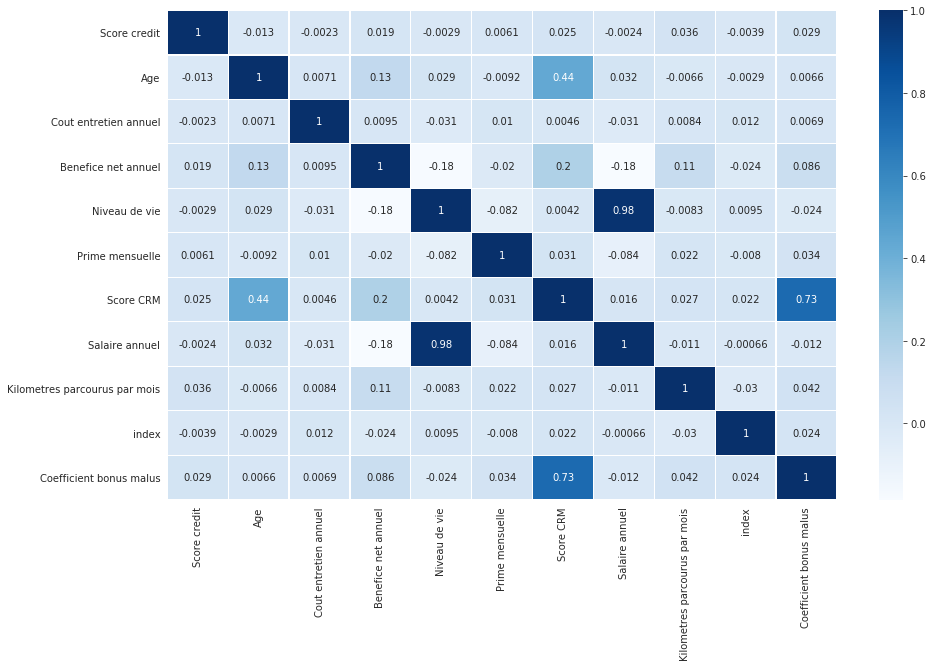

In [ ]:
sns.heatmap(data[NUMERICAL_COLUMNS].corr(), annot=True, cmap='Blues',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(15,9)
plt.show()

### Liens entre target et variables catégorielles (Distributions)

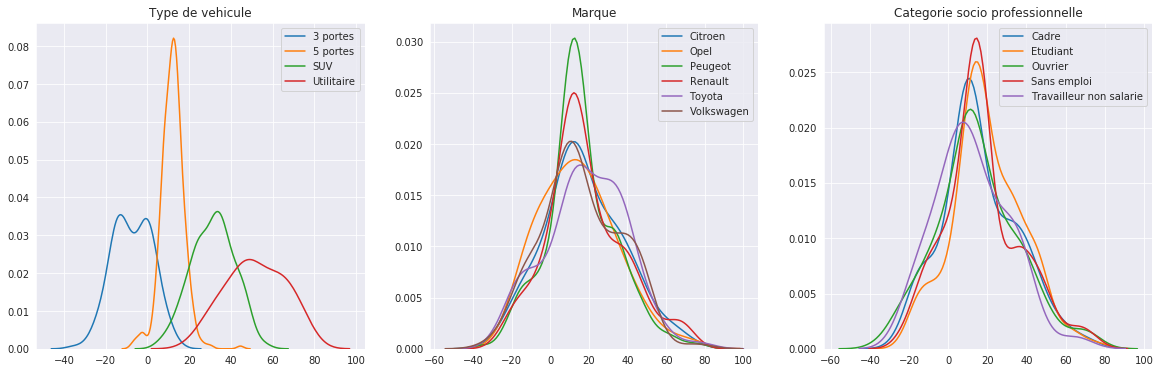

In [ ]:
plt.figure(figsize=(20,6))

i=1
for categorical in CATEGORICAL_COLUMNS:
  plt.subplot(1,3,i)

  for label, df in data[[categorical, TARGET_COLUMN]].groupby(categorical):
    sns.kdeplot(data=df[TARGET_COLUMN], label=label)

  plt.title(categorical)
  i=i+1

In [ ]:
NUMERICAL_COLUMNS

{'Age',
 'Benefice net annuel',
 'Coefficient bonus malus',
 'Cout entretien annuel',
 'Kilometres parcourus par mois',
 'Niveau de vie',
 'Prime mensuelle',
 'Salaire annuel',
 'Score CRM',
 'Score credit',
 'index'}

## Preprocessing

In [ ]:
data_one_hot = pd.get_dummies(data, columns=CATEGORICAL_COLUMNS)
data_one_hot.head()

,index,Age,Prime mensuelle,Kilometres parcourus par mois,Coefficient bonus malus,Score CRM,Niveau de vie,Salaire annuel,Score credit,Cout entretien annuel,Benefice net annuel,Type de vehicule_3 portes,Type de vehicule_5 portes,Type de vehicule_SUV,Type de vehicule_Utilitaire,Marque_Citroen,Marque_Opel,Marque_Peugeot,Marque_Renault,Marque_Toyota,Marque_Volkswagen,Categorie socio professionnelle_Cadre,Categorie socio professionnelle_Etudiant,Categorie socio professionnelle_Ouvrier,Categorie socio professionnelle_Sans emploi,Categorie socio professionnelle_Travailleur non salarie
0,0,58.0,40.0,973,106,164,3762,20420,309,801,54.998558,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
1,1,26.0,27.0,637,95,126,3445,25750,135,667,7.840930,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
2,2,27.0,26.0,978,136,153,986,6790,786,696,46.078889,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
3,3,22.0,8.0,771,96,111,2366,15140,320,765,-11.048213,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,4,60.0,20.0,758,101,149,1441,12850,287,808,1.180078,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0


## Train/test split + data selection 

In [ ]:
#Suppression des variables qui ne seront pas utilisées pour entrainer les modèles
columns_to_keep = list(data_one_hot.columns)
columns_to_keep.remove("index")
columns_to_keep.remove("Benefice net annuel")
columns_to_keep.remove("Score credit")
columns_to_keep.remove("Cout entretien annuel")
columns_to_keep.remove("Coefficient bonus malus")


c  = [col for col in columns_to_keep if "Marque" in col]

for v in c:
  columns_to_keep.remove(v)

#Split train et test
x_all = data_one_hot[columns_to_keep].values
y_all = data_one_hot["Benefice net annuel"].values

X_train, X_test, y_train, y_test = train_test_split(
      x_all, y_all, test_size=0.20, random_state=42)     

In [ ]:
columns_to_keep

['Age',
 'Prime mensuelle',
 'Kilometres parcourus par mois',
 'Score CRM',
 'Niveau de vie',
 'Salaire annuel',
 'Type de vehicule_3 portes',
 'Type de vehicule_5 portes',
 'Type de vehicule_SUV',
 'Type de vehicule_Utilitaire',
 'Categorie socio professionnelle_Cadre',
 'Categorie socio professionnelle_Etudiant',
 'Categorie socio professionnelle_Ouvrier',
 'Categorie socio professionnelle_Sans emploi',
 'Categorie socio professionnelle_Travailleur non salarie']

## Méthodes utiles

In [ ]:
def get_rmse(actual, predicted):
  return math.sqrt(mean_squared_error(actual, predicted))

#Méthode entrainant modèle
def evaluate_sk_model(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  
  y_train_preds = model.predict(X_train)
  y_test_preds = model.predict(X_test)
  print("RMSE train : {}\nRMSE test : {}".format(get_rmse(y_train, y_train_preds), get_rmse(y_test, y_test_preds)))

#Méthode cross validation
def cross_val_score(model, X, y, deep): 
  n_split = 5
  errors_test = []
  errors_train = []

  for train_index,test_index in KFold(n_split).split(X):
    x_train,x_test=X[train_index],X[test_index]
    y_train,y_test=y[train_index],y[test_index]
    print(".")

    #Si deep learning : unscaler les prédictions, le modèle étant entrainé sur des données normalisées
    if deep:
      _ , scalerY, X_train_scaled, X_test_scaled, y_train_scaled = scale_data(x_train, y_train, x_test)
      model.fit(X_train_scaled, y_train_scaled, epochs=700, batch_size=10, verbose=0)
      y_train_preds = scalerY.inverse_transform(model.predict(X_train_scaled))
      y_test_preds = scalerY.inverse_transform(model.predict(X_test_scaled))

    #Si machine learning : pas de unscaling
    else:
      model.fit(x_train, y_train)   
      y_train_preds = model.predict(x_train)
      y_test_preds = model.predict(x_test)

    errors_train.append(get_rmse(y_train, y_train_preds))  
    errors_test.append(get_rmse(y_test, y_test_preds))

  return np.asarray(errors_train).mean(), np.asarray(errors_test).mean()

#Méthode scaler données + retourner scaler et données scalées
def scale_data(X_train, y_train, X_test):
  scalerX = StandardScaler()
  scalerY = StandardScaler()
  scalerX.fit(X_train)
  scalerY.fit(y_train.reshape(-1,1))

  X_train_scaled = scalerX.transform(X_train)
  y_train_scaled = scalerY.transform(y_train.reshape(-1,1))
  X_test_scaled = scalerX.transform(X_test)
  
  return scalerX, scalerY, X_train_scaled, X_test_scaled, y_train_scaled

#Construction du réseau de neurones
def build_model():
  inputs = Input(shape=(len(columns_to_keep),))
  dense2 = Dense(10, activation='relu', kernel_initializer="random_uniform")(inputs)
  dense3 = Dense(5, activation='relu', kernel_initializer="random_uniform")(dense2)
  predictions = Dense(1, activation='linear', kernel_initializer="random_uniform")(dense3)

  model = Model(inputs=inputs, outputs=predictions)
  model.compile(optimizer="adam",
                  loss='mae',
                  metrics=['mae'],
               )
  return model  

In [ ]:
results = []

## Regression linéaire 

In [ ]:
print("Score on train_test")
lasso = LinearRegression()
evaluate_sk_model(lasso, X_train, y_train, X_test, y_test)
print("\n")
print("Score with cross validation")
train_err, test_err = cross_val_score(lasso, x_all, y_all, False)
print("Mean error on train set : {}".format(train_err))
print("Mean error on test set : {}".format(test_err))
results.append({"model":"linear regression", "train_error":train_err, "test_error":test_err})

Score on train_test
RMSE train : 6.8930096846807425
RMSE test : 6.589509407357777


Score with cross validation
.
.
.
.
.
Mean error on train set : 6.806360301136271
Mean error on test set : 6.903441425295513


## Random forest

In [ ]:
print("Score on train_test")
forest = RandomForestRegressor(random_state=1, n_estimators=500)
evaluate_sk_model(forest, X_train, y_train, X_test, y_test)
print("\n")
print("Score with cross validation")
train_err, test_err = cross_val_score(forest, x_all, y_all, False)
print("Mean error on train set : {}".format(train_err))
print("Mean error on test set : {}".format(test_err))
results.append({"model":"Random forest", "train_error":train_err, "test_error":test_err})

Score on train_test
RMSE train : 1.1143332803658546
RMSE test : 3.2215188039400053


Score with cross validation
.
.
.
.
.
Mean error on train set : 1.1290071870905916
Mean error on test set : 2.925073376398317


## XGBoost

In [ ]:
import xgboost as xgb

print("Score on train_test")
xgb = xgb.XGBRegressor(learning_rate=0.15, n_estimators=500, seed=1, eval_metric="rmse", objective="reg:squarederror")
evaluate_sk_model(xgb, X_train, y_train, X_test, y_test)
print("\n")
print("Score with cross validation")
train_err, test_err = cross_val_score(xgb, x_all, y_all, False)
print("Mean error on train set : {}".format(train_err))
print("Mean error on test set : {}".format(test_err))
results.append({"model":"XGBoost", "train_error":train_err, "test_error":test_err})

Score on train_test
RMSE train : 0.30667626141923426
RMSE test : 1.655219446798805


Score with cross validation
.
.
.
.
.
Mean error on train set : 0.31035104135361596
Mean error on test set : 1.844958499542248


## Neural network

In [ ]:
# Scaler données puis construire le modèle
_ , scalerY, X_train_scaled, X_test_scaled, y_train_scaled = scale_data(X_train, y_train, X_test)
model = build_model()

print("Score on train_test")
model.fit(X_train_scaled, y_train_scaled, epochs=700, batch_size=10, verbose=0)
y_train_preds = scalerY.inverse_transform(model.predict(X_train_scaled))
y_test_preds = scalerY.inverse_transform(model.predict(X_test_scaled))
print("RMSE train : {} \nRMSE test: {}".format(get_rmse(y_train, y_train_preds), get_rmse(y_test, y_test_preds)))

print("\n")
print("Score with cross validation")
train_err, test_err = cross_val_score(model, x_all, y_all, True)
print("Mean error on train set : {}".format(train_err))
print("Mean error on test set : {}".format(test_err))
results.append({"model":"Neural network", "train_error":train_err, "test_error":test_err})

Score on train_test
RMSE train : 1.0581998993957167 
RMSE test: 1.133346624910338


Score with cross validation
.
.
.
.
.
Mean error on train set : 1.0295708583759957
Mean error on test set : 1.1399978237422672


## Résultats

In [ ]:
df_res = pd.DataFrame(results)
df_res

,model,train_error,test_error
0,linear regression,6.806360,6.903441
1,Random forest,1.129007,2.925073
2,XGBoost,0.310351,1.844958
3,Neural network,1.029571,1.139998


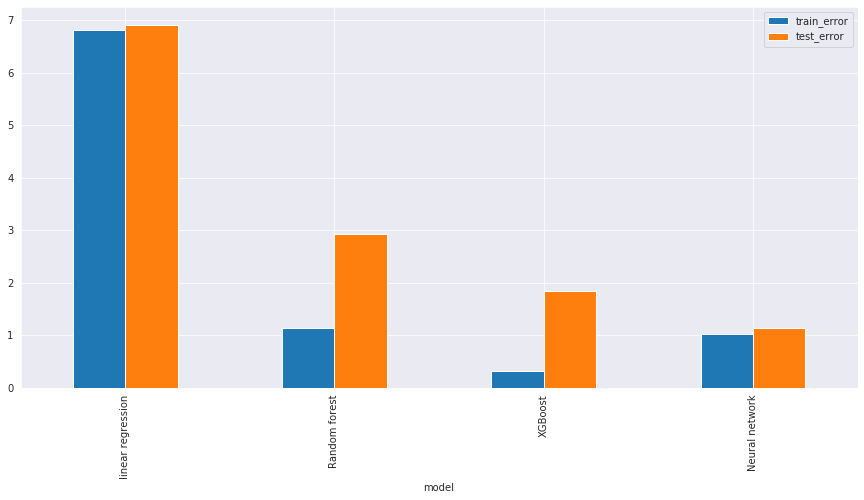

In [ ]:
df_res.set_index("model").plot.bar(figsize=(15,7))

## Make predictions

In [ ]:
scoring = pd.read_csv("scoring_dataset_axaggpdsc.csv")
scoring.head()

,index,Age,Prime mensuelle,Categorie socio professionnelle,Kilometres parcourus par mois,Coefficient bonus malus,Type de vehicule,Score CRM,Niveau de vie,Marque,Salaire annuel,Score credit,Cout entretien annuel
0,1000,19.0,16.0,Cadre,746,108,Utilitaire,121,4956,Toyota,31600,401,756
1,1001,21.0,14.0,Cadre,694,106,5 portes,125,4531,Opel,34900,833,719
2,1002,29.0,13.0,Cadre,740,110,5 portes,140,9541,NaN,62820,890,1027
3,1003,33.0,2.0,Etudiant,970,99,5 portes,132,6536,Citroen,45450,990,964
4,1004,23.0,6.0,Ouvrier,408,100,5 portes,127,10985,Volkswagen,74270,647,768


In [ ]:
scoring_one_hot = pd.get_dummies(scoring, columns=CATEGORICAL_COLUMNS)
scoring_one_hot.head()

,index,Age,Prime mensuelle,Kilometres parcourus par mois,Coefficient bonus malus,Score CRM,Niveau de vie,Salaire annuel,Score credit,Cout entretien annuel,Type de vehicule_3 portes,Type de vehicule_5 portes,Type de vehicule_SUV,Type de vehicule_Utilitaire,Marque_Citroen,Marque_Opel,Marque_Peugeot,Marque_Renault,Marque_Toyota,Marque_Volkswagen,Categorie socio professionnelle_Cadre,Categorie socio professionnelle_Etudiant,Categorie socio professionnelle_Ouvrier,Categorie socio professionnelle_Sans emploi,Categorie socio professionnelle_Travailleur non salarie
0,1000,19.0,16.0,746,108,121,4956,31600,401,756,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
1,1001,21.0,14.0,694,106,125,4531,34900,833,719,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
2,1002,29.0,13.0,740,110,140,9541,62820,890,1027,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1003,33.0,2.0,970,99,132,6536,45450,990,964,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
4,1004,23.0,6.0,408,100,127,10985,74270,647,768,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


In [ ]:
#Selectionner features à utiliser 
x_scoring = scoring_one_hot[columns_to_keep].values

#Scaler données entrainement et test 
_ , scalerY, X_train_scaled, X_test_scaled, y_train_scaled = scale_data(x_all, y_all, x_scoring)

#Entrainer le model
model = build_model()
model.fit(X_train_scaled, y_train_scaled, epochs=600, batch_size=10, verbose=0)

RMSE train
0.992557052833864


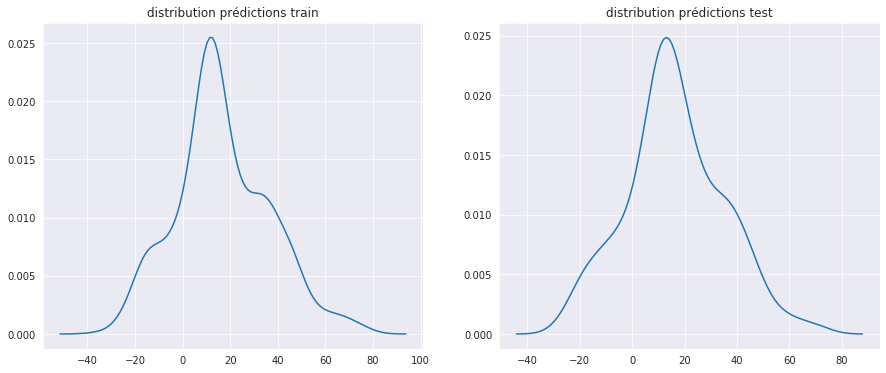

In [ ]:
#Prédictions sur données de train et de test + Unscale

y_train_preds = scalerY.inverse_transform(model.predict(X_train_scaled))
y_test_preds = scalerY.inverse_transform(model.predict(X_test_scaled))

print("RMSE train")
print(get_rmse(y_train_preds, y_all))

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.kdeplot(data=y_train_preds.flatten())
plt.title("distribution prédictions train")
plt.plot()

plt.subplot(1,2,2)
sns.kdeplot(data=y_test_preds.flatten())
plt.title("distribution prédictions test")
plt.plot()

fig.show()

In [ ]:
#Enregister predictions
scoring["predictions"] = y_test_preds
scoring[["index", "predictions"]].to_csv("predictions_yanis.csv")

In [ ]:
scoring[["index", "predictions"]].head()

,index,predictions
0,1000,53.733257
1,1001,5.375835
2,1002,2.481547
3,1003,11.050063
4,1004,-2.055916
